In [57]:
import sys
import torch
from torch_geometric.data import Data

print("Python：" + sys.version)
print("PyTorch：" + torch.__version__)

if torch.cuda.is_available():
    print("CUDA：" + torch.version.cuda)
    print("GPU：" + torch.cuda.get_device_name(0))
    print(f"GPU メモリ: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
else:
    print("GPU is not available. CPUを使用します。")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Python：3.12.11 (main, Jul  3 2025, 17:03:59) [GCC 11.4.0]
PyTorch：2.7.1+cu128
CUDA：12.8
GPU：NVIDIA GeForce RTX 3060
GPU メモリ: 11.6 GB


ノード特徴量の形状: torch.Size([30, 4])
エッジ数: 100
データのデバイス: cuda:0


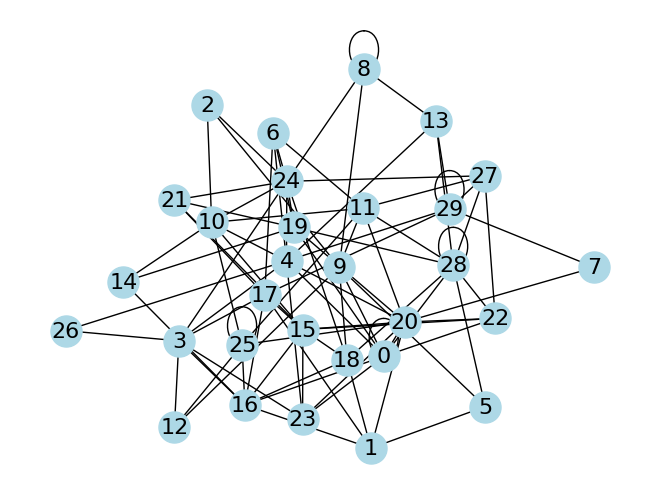

In [43]:
import networkx as nx
import matplotlib.pyplot as plt

# GraphRNN用のデータ読み込み
node_num = 30
edge_num = 100
edge_index = torch.randint(0, node_num, (2, edge_num)).to(device)
x = torch.randn((node_num, 4)).to(device)
data = Data(x=x, edge_index=edge_index)

print(f"ノード特徴量の形状: {data.x.shape}")
print(f"エッジ数: {data.edge_index.size(1)}")
print(f"データのデバイス: {data.x.device}")

# networkxを使ってグラフを可視化（CPUに移動してから）
G = nx.Graph()
G.add_nodes_from(range(node_num))
for i in range(edge_num):
    G.add_edge(edge_index[0, i].item(), edge_index[1, i].item())

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=16)
plt.show()

In [44]:
# --- GraphRNNの基本実装 ---
import torch.nn as nn
import matplotlib.pyplot as plt


class NodeRNN(nn.Module):
    """
    ノードレベルRNN
    各ステップで新しいノードを追加するかどうかを決定
    """
    def __init__(self, input_size, hidden_size, output_size):
        super(NodeRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, h):
        out, h = self.rnn(x, h)
        out = self.fc(out)
        return out, h


class EdgeRNN(nn.Module):
    """
    エッジレベルRNN
    新しく追加されたノードが既存のノードとエッジを形成するかを決定
    """
    def __init__(self, input_size, hidden_size, output_size):
        super(EdgeRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, h):
        out, h = self.rnn(x, h)
        out = self.fc(out)
        return out, h


In [45]:
# --- データ前処理: BFS順序による隣接シーケンス変換 ---
import numpy as np
import networkx as nx
import torch.nn.functional as F
from torch_geometric.utils import to_networkx
import japanize_matplotlib

print("=== データ前処理開始 ===")
print(f"現在のグラフ: {G.number_of_nodes()}ノード, {G.number_of_edges()}エッジ")

# BFS順序による隣接シーケンス変換関数
def bfs_seq(G, start_node):
    """NetworkXグラフからBFSノード順序を生成する"""
    return list(nx.bfs_tree(G, source=start_node).nodes())

# グラフを隣接ベクトルのシーケンスに変換する
def graph_to_adj_seq(G, max_prev_nodes=8):
    """グラフを隣接ベクトルのシーケンスに変換する"""
    nodes = list(G.nodes())
    if len(nodes) == 0:
        return torch.tensor([])
    
    # ランダムな開始ノードからBFS順序を生成
    start_node = np.random.choice(nodes)
    bfs_order = bfs_seq(G, start_node)
    
    # 隣接行列を取得
    adj = nx.to_numpy_array(G, nodelist=bfs_order)
    
    adj_seq = []
    for i in range(1, len(bfs_order)):
        # i番目のノードと、それ以前のノードとの接続関係
        row = adj[i, :i]
        
        # 固定長にパディング（max_prev_nodesまで）
        if len(row) > max_prev_nodes:
            row = row[-max_prev_nodes:]  # 最新のmax_prev_nodes個だけ保持
        
        padded_row = F.pad(torch.tensor(row, dtype=torch.float32),
                          (max_prev_nodes - len(row), 0), "constant", 0)
        adj_seq.append(padded_row)
    
    # シーケンスの終わりを示すEOSトークンを追加
    if adj_seq:  # 空でない場合のみ
        eos = torch.zeros(max_prev_nodes, dtype=torch.float32)
        adj_seq.append(eos)
        return torch.stack(adj_seq)
    else:
        return torch.zeros(1, max_prev_nodes, dtype=torch.float32)

# 各グラフをBFS順序による隣接シーケンスに変換
print("\n=== BFS隣接シーケンス変換 ===")
max_prev_nodes = 6  # 小さなグラフ用に調整
adj_sequences = []

for i, graph in enumerate([G]):  # ここでは単一のグラフを使用
    try:
        adj_seq = graph_to_adj_seq(graph, max_prev_nodes=max_prev_nodes)
        if adj_seq.numel() > 0:
            adj_sequences.append(adj_seq)
            print(f"グラフ {i+1}: 隣接シーケンス形状 {adj_seq.shape}")
    except Exception as e:
        print(f"グラフ {i+1}の変換でエラー: {e}")

print(f"\n変換成功したシーケンス数: {len(adj_sequences)}")

=== データ前処理開始 ===
現在のグラフ: 30ノード, 91エッジ

=== BFS隣接シーケンス変換 ===
グラフ 1: 隣接シーケンス形状 torch.Size([30, 6])

変換成功したシーケンス数: 1


=== GraphRNN学習開始 ===
Epoch   0/50, Loss: 360.217163


Epoch  10/50, Loss: 335.159668
Epoch  20/50, Loss: 313.904175
Epoch  30/50, Loss: 293.562256
Epoch  40/50, Loss: 270.456451
学習完了!


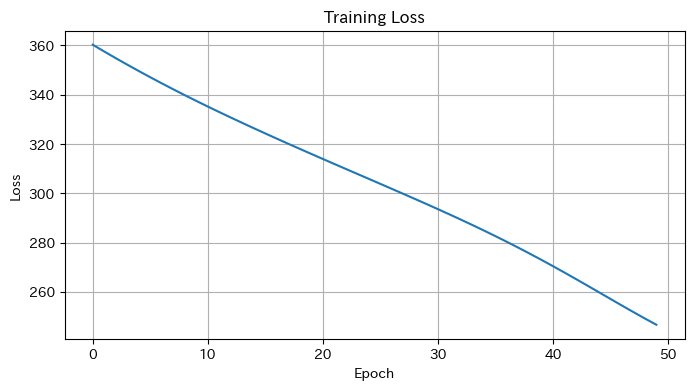

In [46]:
# --- 学習機能: BCE損失による教師あり学習 ---
import torch.optim as optim

def train_graphrnn_simple(node_rnn, edge_rnn, training_graphs, epochs=30, learning_rate=0.001):
    """
    GraphRNNの基本的な学習関数
    
    Args:
        node_rnn: ノードレベルRNN
        edge_rnn: エッジレベルRNN
        training_graphs: 学習用グラフのリスト
        epochs: エポック数
        learning_rate: 学習率
    """
    print("=== GraphRNN学習開始 ===")
    
    # オプティマイザーと損失関数
    optimizer_node = optim.Adam(node_rnn.parameters(), lr=learning_rate)
    optimizer_edge = optim.Adam(edge_rnn.parameters(), lr=learning_rate)
    criterion = nn.BCELoss()
    
    train_losses = []
    
    for epoch in range(epochs):
        total_loss = 0
        
        for graph in training_graphs:
            # グラフからBFS順序での隣接行列を取得
            if isinstance(graph, nx.Graph) and graph.number_of_nodes() > 1:
                adj_matrix = nx.to_numpy_array(graph)
                num_nodes = graph.number_of_nodes()
            else:
                continue
            
            # ノードレベルの学習
            h_node = torch.zeros(1, 1, node_rnn.hidden_size)
            node_loss = 0
            
            for i in range(num_nodes):
                node_input = torch.tensor([[[1.0]]], dtype=torch.float32)  # ノード存在入力
                node_output, h_node = node_rnn(node_input, h_node)
                target = torch.tensor([[[1.0]]], dtype=torch.float32)  # ノード存在目標
                node_loss += criterion(torch.sigmoid(node_output), target)
            
            # エッジレベルの学習
            h_edge = torch.zeros(1, 1, edge_rnn.hidden_size)
            edge_loss = 0
            
            for i in range(num_nodes):
                for j in range(i):
                    edge_input = torch.tensor([[[1.0]]], dtype=torch.float32)
                    edge_output, h_edge = edge_rnn(edge_input, h_edge)
                    target = torch.tensor([[[adj_matrix[i, j]]]], dtype=torch.float32)
                    edge_loss += criterion(torch.sigmoid(edge_output), target)
            
            # バックプロパゲーション
            optimizer_node.zero_grad()
            optimizer_edge.zero_grad()
            
            total_loss_step = node_loss + edge_loss
            total_loss_step.backward()
            
            optimizer_node.step()
            optimizer_edge.step()
            
            total_loss += total_loss_step.item()
        
        avg_loss = total_loss / len(training_graphs)
        train_losses.append(avg_loss)
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch:3d}/{epochs}, Loss: {avg_loss:.6f}")
    
    print("学習完了!")
    return train_losses


node_rnn = NodeRNN(input_size=1, hidden_size=16, output_size=1)
edge_rnn = EdgeRNN(input_size=1, hidden_size=16, output_size=1)

# 学習実行
train_losses = train_graphrnn_simple(
    node_rnn=node_rnn, 
    edge_rnn=edge_rnn, 
    training_graphs=[graph for graph in [G] if isinstance(graph, nx.Graph)],
    epochs=50,
    learning_rate=0.001
)

# 学習曲線の表示
plt.figure(figsize=(8, 4))
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

=== グラフ生成開始（最大50ノード） ===
ノード0: 追加確率 0.686 -> 追加
ノード1: 追加確率 0.774 -> 追加
エッジ(1,0): 確率 0.424 -> 追加
ノード2: 追加確率 0.793 -> 追加
エッジ(2,0): 確率 0.377 -> 追加
エッジ(2,1): 確率 0.366 -> 追加
ノード3: 追加確率 0.787 -> 追加
エッジ(3,0): 確率 0.356 -> 追加
ノード4: 追加確率 0.786 -> 追加
ノード5: 追加確率 0.789 -> 追加
ノード6: 追加確率 0.791 -> 追加
ノード7: 追加確率 0.791 -> 追加
ノード8: 追加確率 0.791 -> 追加
ノード9: 追加確率 0.791 -> 追加
ノード10: 追加確率 0.791 -> 追加
ノード11: 追加確率 0.791 -> 追加
ノード12: 追加確率 0.791 -> 追加
ノード13: 追加確率 0.791 -> 追加
ノード14: 追加確率 0.791 -> 追加
ノード15: 追加確率 0.791 -> 追加
ノード16: 追加確率 0.791 -> 追加
ノード17: 追加確率 0.791 -> 追加
ノード18: 追加確率 0.791 -> 追加
ノード19: 追加確率 0.791 -> 追加
ノード20: 追加確率 0.791 -> 追加
ノード21: 追加確率 0.791 -> 追加
ノード22: 追加確率 0.791 -> 追加
ノード23: 追加確率 0.791 -> 追加
ノード24: 追加確率 0.791 -> 追加
ノード25: 追加確率 0.791 -> 追加
ノード26: 追加確率 0.791 -> 追加
ノード27: 追加確率 0.791 -> 追加
ノード28: 追加確率 0.791 -> 追加
ノード29: 追加確率 0.791 -> 追加
ノード30: 追加確率 0.791 -> 追加
ノード31: 追加確率 0.791 -> 追加
ノード32: 追加確率 0.791 -> 追加
ノード33: 追加確率 0.791 -> 追加
ノード34: 追加確率 0.791 -> 追加
ノード35: 追加確率 0.791 -> 追加
ノード36: 追加確率 0.791 -> 

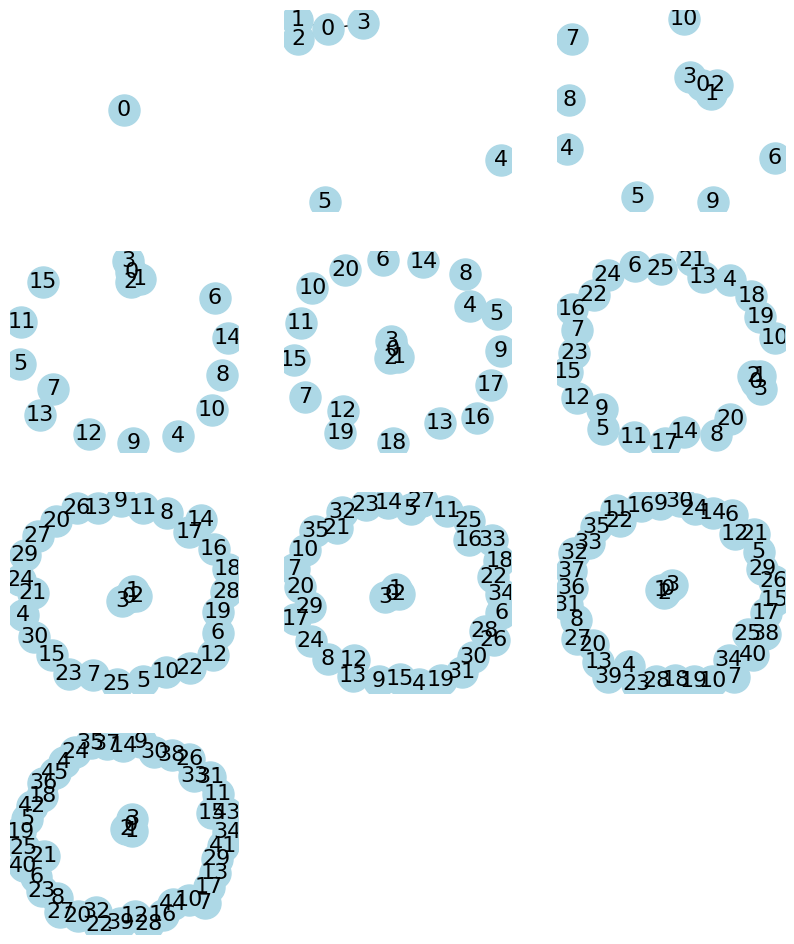

In [72]:
# --- 生成機能: 学習されたモデルを基に自己回帰的なグラフ生成 ---

def generate_graph(node_rnn, edge_rnn, max_nodes=6):
    """
    学習されたGraphRNNを使ってグラフを自己回帰的に生成する
    
    Args:
        node_rnn: 学習済みノードレベルRNN
        edge_rnn: 学習済みエッジレベルRNN
        max_nodes: 生成する最大ノード数
    
    Returns:
        graphs: 生成されたNetworkXグラフ
    """
    node_rnn.eval()
    edge_rnn.eval()
    
    graphs = []
    graph = nx.Graph()
    h_node = torch.zeros(1, 1, node_rnn.hidden_size)
    h_edge = torch.zeros(1, 1, edge_rnn.hidden_size)
    
    print(f"=== グラフ生成開始（最大{max_nodes}ノード） ===")
    
    with torch.no_grad():
        for i in range(max_nodes):
            # ノード追加の決定
            node_input = torch.tensor([[[1.0]]], dtype=torch.float32)
            node_output, h_node = node_rnn(node_input, h_node)
            
            # ノード追加確率
            node_prob = torch.sigmoid(node_output).item()
            print(f"ノード{i}: 追加確率 {node_prob:.3f}", end="")
            
            if node_prob > 0.5:
                graph.add_node(i)
                print(" -> 追加")
                
                # 既存のノードとのエッジを決定
                for j in range(i):
                    if j in graph.nodes():
                        edge_input = torch.tensor([[[1.0]]], dtype=torch.float32)
                        edge_output, h_edge = edge_rnn(edge_input, h_edge)
                        
                        edge_prob = torch.sigmoid(edge_output).item()
                        
                        if edge_prob > 0.35:
                            graph.add_edge(i, j)
                            print(f"エッジ({i},{j}): 確率 {edge_prob:.3f} -> 追加")
            else:
                print(" -> スキップ")
                # ノード追加確率が低い場合は生成終了
                break
            graphs.append(graph.copy())
    return graphs

generate_graph = generate_graph(node_rnn, edge_rnn, max_nodes=50)
plt.figure(figsize=(10, 12))
for i, graph in enumerate(generate_graph):
    if i % 5 != 0:
        continue
    plt.subplot(4, 3, (i // 5) + 1)
    pos = nx.spring_layout(graph)
    nx.draw(graph, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=16)
    # plt.title(f"Generated Graph with {i+1} Nodes")
plt.show()